Name: Vedant Modi
<br>
[1]Gary Doran, Emily Dunkel, Steven Luand Kiri Wagstaff, “Mars orbital image (HiRISE) labeled data set version 3.2”. Zenodo, Sep. 16, 2020. doi: 10.5281/zenodo.4002935.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
import os
import os.path as op
import json
from pathlib import Path
import shutil
import logging
import numpy as np
from tqdm import tqdm
from skimage import io
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications import VGG16, ResNet50, EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
import random
from PIL import Image
import cv2

### For Google Colab

In [ ]:
# Logging configuration
logging.basicConfig(level=logging.INFO,
                    datefmt='%H:%M:%S',
                    format='%(asctime)s | %(levelname)-5s | %(module)-15s | %(message)s')

IMAGE_SIZE = (299, 299)  # All images contained in this dataset are 299x299 (originally, to match Inception v3 input size)
SEED = 17

# Head directory containing all image subframes. Update with the relative path of your data directory
data_head_dir = Path('/content/drive/MyDrive/Colab Notebooks/DCSI_Project/dataset/data')

# Find all subframe directories
subdirs = [Path(subdir.stem) for subdir in data_head_dir.iterdir() if subdir.is_dir()]
src_image_ids = ['_'.join(a_path.name.split('_')[:3]) for a_path in subdirs]

In [ ]:
# Load train/val/test subframe IDs
def load_text_ids(file_path):
    """Simple helper to load all lines from a text file"""
    with open(file_path, 'r') as f:
        lines = [line.strip() for line in f.readlines()]
    return lines

# Load the subframe names for the three data subsets
train_ids = load_text_ids('/content/drive/MyDrive/Colab Notebooks/DCSI_Project/dataset/Source Images/train_source_images.txt')
validate_ids = load_text_ids('/content/drive/MyDrive/Colab Notebooks/DCSI_Project/dataset/Source Images/val_source_images.txt')
test_ids = load_text_ids('/content/drive/MyDrive/Colab Notebooks/DCSI_Project/dataset/Source Images/test_source_images.txt')

# Generate a list containing the dataset split for the matching subdirectory names
subdir_splits = []
for src_id in src_image_ids:
    if src_id in train_ids:
        subdir_splits.append('train')
    elif src_id in validate_ids:
        subdir_splits.append('validate')
    elif(src_id in test_ids):
        subdir_splits.append('test')
    else:
        logging.warning(f'{src_id}: Did not find designated split in train/validate/test list.')
        subdir_splits.append(None)

### For Jupyter Notebook

In [2]:
# Logging configuration
logging.basicConfig(level=logging.INFO,
                    datefmt='%H:%M:%S',
                    format='%(asctime)s | %(levelname)-5s | %(module)-15s | %(message)s')

IMAGE_SIZE = (299, 299)  # All images contained in this dataset are 299x299 (originally, to match Inception v3 input size)
SEED = 17

# Head directory containing all image subframes. Update with the relative path of your data directory
data_head_dir = Path('./data')

# Find all subframe directories
subdirs = [Path(subdir.stem) for subdir in data_head_dir.iterdir() if subdir.is_dir()]
src_image_ids = ['_'.join(a_path.name.split('_')[:3]) for a_path in subdirs]

In [3]:
# Load train/val/test subframe IDs
def load_text_ids(file_path):
    """Simple helper to load all lines from a text file"""
    with open(file_path, 'r') as f:
        lines = [line.strip() for line in f.readlines()]
    return lines

# Load the subframe names for the three data subsets
train_ids = load_text_ids('./train_source_images.txt')
validate_ids = load_text_ids('./val_source_images.txt')
test_ids = load_text_ids('./test_source_images.txt')

# Generate a list containing the dataset split for the matching subdirectory names
subdir_splits = []
for src_id in src_image_ids:
    if src_id in train_ids:
        subdir_splits.append('train')
    elif src_id in validate_ids:
        subdir_splits.append('validate')
    elif(src_id in test_ids):
        subdir_splits.append('test')
    else:
        logging.warning(f'{src_id}: Did not find designated split in train/validate/test list.')
        subdir_splits.append(None)

# Loading and pre processing the data

### I have displayed results using three approaches to highlight the impact of augmentation.

1. The original unaugmented data.

2. Random augmentation applied to 33% of the training data which is appended to the original training data. This results in a training set 133% the size of the original set.

3. Random augmentation applied to the entire training data, without appending any new data and keeping the size the same.

In [4]:
def load_and_preprocess(img_loc, label):
    def _inner_function(img_loc, label):
        img_loc_str = img_loc.numpy().decode('utf-8')

        img = Image.open(img_loc_str).convert('RGB')

        img = np.array(img)
        img = tf.image.resize(img, [299, 299])

        img = img / 255.0

        label = 1 if label.numpy().decode('utf-8') == 'frost' else 0

        return img, label

    X, y = tf.py_function(_inner_function, [img_loc, label], [tf.float32, tf.int64])

    X.set_shape([299, 299, 3])
    y.set_shape([])

    return X, y

def load_subdir_data(dir_path, image_size, seed=None):

    """Helper to create a TF dataset from each image subdirectory"""

    # Grab only the classes that (1) we want to keep and (2) exist in this directory
    tile_dir = dir_path / Path('tiles')
    label_dir = dir_path /Path('labels')

    loc_list = []

    for folder in os.listdir(tile_dir):
        if os.path.isdir(os.path.join(tile_dir, folder)):
            for file in os.listdir(os.path.join(tile_dir, folder)):
                if file.endswith(".png"):
                    loc_list.append((os.path.join(os.path.join(tile_dir, folder), file), folder))

    return loc_list

# Loop over all subframes, loading each into a list
tf_data_train, tf_data_test, tf_data_val = [], [], []
tf_dataset_train, tf_dataset_test, tf_dataset_val = [], [], []

# Update the batch and buffer size as per your model requirements
buffer_size = 64
batch_size = 32

for subdir, split in zip(subdirs, subdir_splits):
    full_path = data_head_dir / subdir
    if split=='validate':
        tf_data_val.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='train':
        tf_data_train.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='test':
        tf_data_test.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))

random.shuffle(tf_data_train)
img_list, label_list = zip(*tf_data_train)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_train = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_train = tf_dataset_train.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_train = tf_dataset_train.shuffle(buffer_size=buffer_size).batch(batch_size)

random.shuffle(tf_data_val)
img_list, label_list = zip(*tf_data_val)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_val = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_val = tf_dataset_val.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_val = tf_dataset_val.shuffle(buffer_size=buffer_size).batch(batch_size)

random.shuffle(tf_data_test)
img_list, label_list = zip(*tf_data_test)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_test = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_test = tf_dataset_test.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_test = tf_dataset_test.shuffle(buffer_size=buffer_size).batch(batch_size)

2023-12-08 11:22:58.491761: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2023-12-08 11:22:58.491804: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-12-08 11:22:58.491807: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-12-08 11:22:58.492140: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-08 11:22:58.492600: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


#### Augmented Data

In [5]:
def load_and_preprocess(img_loc, label, is_training = True):
    def _inner_function(img_loc, label):
      
        img_loc_str = img_loc.numpy().decode('utf-8')
        img = cv2.imread(img_loc_str)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Apply augmentations
        if is_training:
            img = empirical_regularization(img)
            img = random_crop(img)
            img = random_zoom(img)
            img = random_rotate(img)
            img = random_flip(img)
            img = adjust_contrast(img)
            img = random_translate(img)

        # Resize the image
        img = cv2.resize(img, (299, 299))

        # Normalize the image to the [0, 1] range
        img = img / 255.0
        # Convert label to integer (assuming binary classification)
        label = 1 if label.numpy().decode('utf-8') == 'frost' else 0

        return img, label

    # Wrap the python function
    X, y = tf.py_function(_inner_function, [img_loc, label], [tf.float32, tf.int64])
    # Set the shape of the tensors
    X.set_shape([299, 299, 3])
    y.set_shape([])
    return X, y

def empirical_regularization(img):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply GaussianBlur
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    # Add Gaussian noise
    noisy = blurred + np.random.normal(0, 10, blurred.shape)
    # Clip values to be in [0, 255]
    noisy = np.clip(noisy, 0, 255).astype(np.uint8)
    # Merge channels
    img = cv2.merge([noisy, noisy, noisy])
    return img

def random_crop(img):
    height, width, _ = img.shape
    # Set the cropping region
    top = np.random.randint(0, height // 4)
    bottom = height - np.random.randint(0, height // 4)
    left = np.random.randint(0, width // 4)
    right = width - np.random.randint(0, width // 4)
    # Crop the image
    img = img[top:bottom, left:right, :]
    return img

def random_zoom(img):
    # Randomly select a zoom factor
    zoom_factor = np.random.uniform(0.8, 1.2)
    # Get the zoomed image
    img = cv2.resize(img, (int(img.shape[1] * zoom_factor), int(img.shape[0] * zoom_factor)))
    return img

def random_rotate(img):
    # Randomly select a rotation angle between -15 and 15 degrees
    angle = np.random.uniform(-15, 15)
    # Get the rotation matrix
    M = cv2.getRotationMatrix2D((img.shape[1] / 2, img.shape[0] / 2), angle, 1)
    # Apply the rotation
    img = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))
    return img

def random_flip(img):
    # Randomly flip horizontally
    if np.random.rand() < 0.5:
        img = cv2.flip(img, 1)
    return img

def adjust_contrast(img):
    # Randomly adjust contrast
    alpha = np.random.uniform(0.8, 1.2)
    img = cv2.multiply(img, alpha)
    img = np.clip(img, 0, 255).astype(np.uint8)
    return img

def random_translate(img):
    # Randomly translate the image horizontally and vertically
    tx = np.random.randint(-20, 20)
    ty = np.random.randint(-20, 20)
    M = np.float32([[1, 0, tx], [0, 1, ty]])
    img = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))
    return img

def load_subdir_data(dir_path, image_size, seed=None):

    """Helper to create a TF dataset from each image subdirectory"""

    # Grab only the classes that (1) we want to keep and (2) exist in this directory
    tile_dir = dir_path / Path('tiles')
    label_dir = dir_path /Path('labels')

    loc_list = []

    for folder in os.listdir(tile_dir):
        if os.path.isdir(os.path.join(tile_dir, folder)):
            for file in os.listdir(os.path.join(tile_dir, folder)):
                if file.endswith(".png"):
                    loc_list.append((os.path.join(os.path.join(tile_dir, folder), file), folder))

    return loc_list

# Loop over all subframes, loading each into a list
tf_data_train_aug, tf_data_test, tf_data_val = [], [], []
tf_dataset_train_aug, tf_dataset_test, tf_dataset_val = [], [], []

# Update the batch and buffer size as per your model requirements
buffer_size = 64
batch_size = 32

for subdir, split in zip(subdirs, subdir_splits):
    full_path = data_head_dir / subdir
    if split=='validate':
        tf_data_val.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='train':
        tf_data_train_aug.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='test':
        tf_data_test.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))

random.shuffle(tf_data_train_aug)
img_list, label_list = zip(*tf_data_train_aug)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_train_aug = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_train_aug = tf_dataset_train_aug.map(lambda x, y: load_and_preprocess(x, y, is_training=True), num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_train_aug = tf_dataset_train_aug.shuffle(buffer_size=buffer_size).batch(batch_size)

random.shuffle(tf_data_val)
img_list, label_list = zip(*tf_data_val)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_val = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_val = tf_dataset_val.map(lambda x, y: load_and_preprocess(x, y, is_training=False), num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_val = tf_dataset_val.shuffle(buffer_size=buffer_size).batch(batch_size)

random.shuffle(tf_data_test)
img_list, label_list = zip(*tf_data_test)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_test = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_test = tf_dataset_test.map(lambda x, y: load_and_preprocess(x, y, is_training=False), num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_test = tf_dataset_test.shuffle(buffer_size=buffer_size).batch(batch_size)

In [6]:
aug_dataset_size = tf.data.experimental.cardinality(tf_dataset_train_aug).numpy()

# Calculate the number of samples to concatenate (33% of aug_dataset_size)
concat_size = int(0.33 * aug_dataset_size)

# Shuffle tf_dataset_train_aug and take the first concat_size elements
tf_dataset_train_aug_shuffled = tf_dataset_train_aug.shuffle(aug_dataset_size, reshuffle_each_iteration=False)
tf_dataset_train_aug_concat = tf_dataset_train_aug_shuffled.take(concat_size)

# Concatenate tf_dataset_train and tf_dataset_train_aug_concat
tf_dataset_train_aug_final = tf.data.Dataset.concatenate(tf_dataset_train, tf_dataset_train_aug_concat)

In [7]:
print(type(tf_dataset_test))

<class 'tensorflow.python.data.ops.batch_op._BatchDataset'>


In [8]:
tf_dataset_test

<_BatchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [9]:
for images, labels in tf_dataset_train_aug.take(1):
    print(images.shape)
    print(labels.shape)

(32, 299, 299, 3)
(32,)


In [10]:
for images, labels in tf_dataset_train_aug_final.take(1):
    print(images.shape)
    print(labels.shape)

(32, 299, 299, 3)
(32,)


In [11]:
for images, labels in tf_dataset_train_aug_final.take(1):
    print(images.dtype, labels.dtype)

<dtype: 'float32'> <dtype: 'int64'>


## CNN without Data Augmentation

Epoch 1/25
257/257 [==============================] - 583s 2s/step - loss: 1.0469 - accuracy: 0.8378 - val_loss: 1.2737 - val_accuracy: 0.3240
Epoch 2/25
257/257 [==============================] - 44s 172ms/step - loss: 0.5105 - accuracy: 0.8996 - val_loss: 1.0505 - val_accuracy: 0.5495
Epoch 3/25
257/257 [==============================] - 44s 170ms/step - loss: 0.3492 - accuracy: 0.9309 - val_loss: 0.3775 - val_accuracy: 0.9389
Epoch 4/25
257/257 [==============================] - 44s 171ms/step - loss: 0.2941 - accuracy: 0.9408 - val_loss: 3.4740 - val_accuracy: 0.4555
Epoch 5/25
257/257 [==============================] - 44s 171ms/step - loss: 0.2308 - accuracy: 0.9515 - val_loss: 0.5605 - val_accuracy: 0.9086
Epoch 6/25
257/257 [==============================] - 43s 168ms/step - loss: 0.2282 - accuracy: 0.9505 - val_loss: 1.5414 - val_accuracy: 0.6701
Epoch 7/25
257/257 [==============================] - 44s 171ms/step - loss: 0.2219 - accuracy: 0.9519 - val_loss: 2.9955 - val_accu

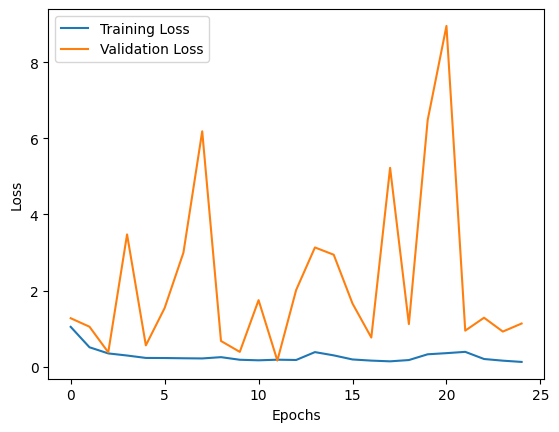

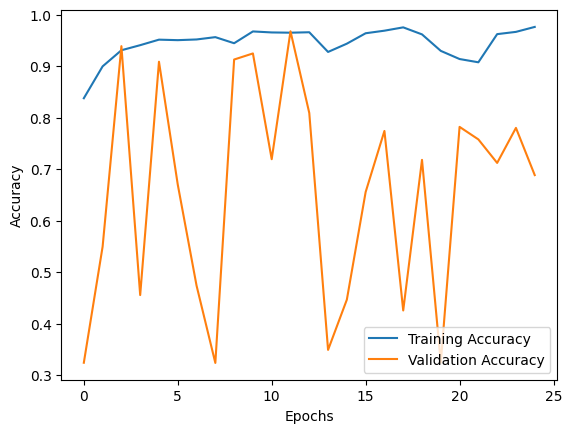

1/1 [==============================] - 0s 47ms/step
              precision    recall  f1-score   support

           0       0.40      1.00      0.57      1594
           1       1.00      0.00      0.00      2438

    accuracy                           0.40      4032
   macro avg       0.70      0.50      0.28      4032
weighted avg       0.76      0.40      0.22      4032

126/126 [==============================] - 14s 106ms/step - loss: 0.4091 - accuracy: 0.9127
Test Loss: 0.40909087657928467, Test Accuracy: 0.9126983880996704
[[1594    0]
 [2438    0]]


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
image_height = 299
image_width = 299
image_channels = 3

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(image_height, image_width, image_channels)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())

model.add(layers.Dropout(0.3))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.BatchNormalization())

model.add(layers.Dense(1, activation='sigmoid'))


model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = model.fit(tf_dataset_train,
                    epochs=25,
                    validation_data=tf_dataset_val,
                    callbacks=[early_stopping])


plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


y_true = []
y_pred = []

for images, labels in tf_dataset_test:
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(model.predict(images), axis=1))

print(classification_report(y_true, y_pred, zero_division=1))

test_loss, test_accuracy = model.evaluate(tf_dataset_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

confusion_mtx = confusion_matrix(y_true, y_pred)
print(confusion_mtx)

model.save('CNN.h5')
loaded_model = tf.keras.models.load_model('CNN.h5')

## CNN with Data Augmentation Appended

Epoch 1/25
341/341 [==============================] - 664s 2s/step - loss: 0.9703 - accuracy: 0.7625 - val_loss: 1.1257 - val_accuracy: 0.4998
Epoch 2/25
341/341 [==============================] - 103s 301ms/step - loss: 0.5516 - accuracy: 0.8167 - val_loss: 1.8623 - val_accuracy: 0.6898
Epoch 3/25
341/341 [==============================] - 102s 299ms/step - loss: 0.4536 - accuracy: 0.8371 - val_loss: 3.5603 - val_accuracy: 0.3237
Epoch 4/25
341/341 [==============================] - 102s 299ms/step - loss: 0.4361 - accuracy: 0.8448 - val_loss: 2.8051 - val_accuracy: 0.7092
Epoch 5/25
341/341 [==============================] - 103s 301ms/step - loss: 0.4980 - accuracy: 0.8229 - val_loss: 3.0504 - val_accuracy: 0.3276
Epoch 6/25
341/341 [==============================] - 102s 299ms/step - loss: 0.4331 - accuracy: 0.8400 - val_loss: 2.0869 - val_accuracy: 0.5541
Epoch 7/25
341/341 [==============================] - 102s 299ms/step - loss: 0.3838 - accuracy: 0.8511 - val_loss: 1.5030 - va

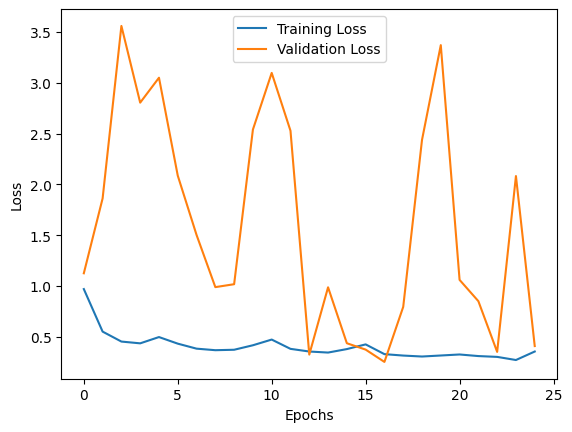

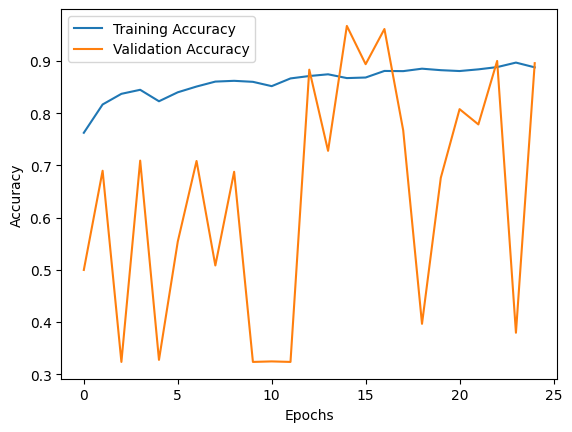

1/1 [==============================] - 0s 50ms/step
              precision    recall  f1-score   support

           0       0.40      1.00      0.57      1594
           1       1.00      0.00      0.00      2438

    accuracy                           0.40      4032
   macro avg       0.70      0.50      0.28      4032
weighted avg       0.76      0.40      0.22      4032

126/126 [==============================] - 14s 109ms/step - loss: 1.2907 - accuracy: 0.6277
Test Loss: 1.2906802892684937, Test Accuracy: 0.6277281641960144
[[1594    0]
 [2438    0]]


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
image_height = 299
image_width = 299
image_channels = 3

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(image_height, image_width, image_channels)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())

model.add(layers.Dropout(0.3))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.BatchNormalization())

model.add(layers.Dense(1, activation='sigmoid'))


model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = model.fit(tf_dataset_train_aug_final,
                    epochs=25,
                    validation_data=tf_dataset_val,
                    callbacks=[early_stopping])


plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


y_true = []
y_pred = []

for images, labels in tf_dataset_test:
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(model.predict(images), axis=1))

print(classification_report(y_true, y_pred, zero_division=1))

test_loss, test_accuracy = model.evaluate(tf_dataset_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

confusion_mtx = confusion_matrix(y_true, y_pred)
print(confusion_mtx)

model.save('CNN_Aug.h5')
loaded_model = tf.keras.models.load_model('CNN_Aug.h5')

## CNN with Data Augmentation

Epoch 1/25
257/257 [==============================] - 72s 267ms/step - loss: 1.1834 - accuracy: 0.5754 - val_loss: 0.9574 - val_accuracy: 0.3375
Epoch 2/25
257/257 [==============================] - 69s 267ms/step - loss: 0.7442 - accuracy: 0.6150 - val_loss: 1.7209 - val_accuracy: 0.3237
Epoch 3/25
257/257 [==============================] - 69s 268ms/step - loss: 0.6936 - accuracy: 0.6308 - val_loss: 4.7680 - val_accuracy: 0.6609
Epoch 4/25
257/257 [==============================] - 69s 267ms/step - loss: 0.6436 - accuracy: 0.6861 - val_loss: 0.9205 - val_accuracy: 0.4045
Epoch 5/25
257/257 [==============================] - 69s 267ms/step - loss: 0.6034 - accuracy: 0.7145 - val_loss: 0.7521 - val_accuracy: 0.4045
Epoch 6/25
257/257 [==============================] - 69s 266ms/step - loss: 0.5405 - accuracy: 0.7715 - val_loss: 12.2285 - val_accuracy: 0.3237
Epoch 7/25
257/257 [==============================] - 70s 269ms/step - loss: 0.5189 - accuracy: 0.7855 - val_loss: 6.6841 - val_a

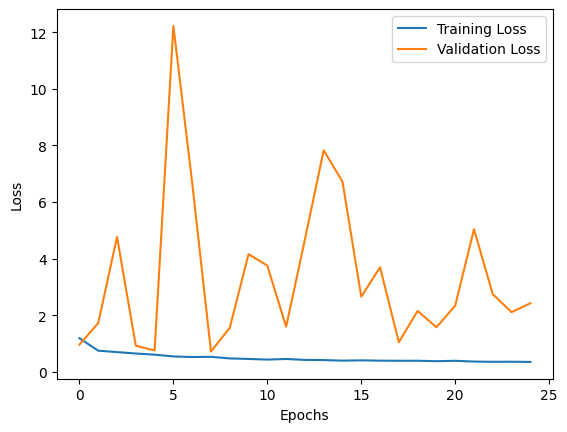

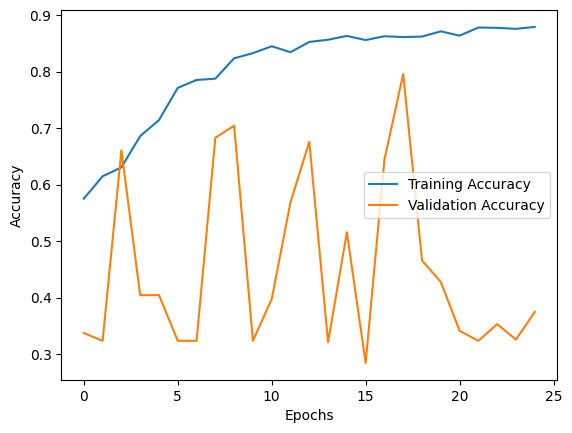

1/1 [==============================] - 0s 51ms/step
              precision    recall  f1-score   support

           0       0.40      1.00      0.57      1594
           1       1.00      0.00      0.00      2438

    accuracy                           0.40      4032
   macro avg       0.70      0.50      0.28      4032
weighted avg       0.76      0.40      0.22      4032

126/126 [==============================] - 14s 110ms/step - loss: 4.4383 - accuracy: 0.4053
Test Loss: 4.438337802886963, Test Accuracy: 0.4052579402923584
[[1594    0]
 [2438    0]]


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
image_height = 299
image_width = 299
image_channels = 3

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(image_height, image_width, image_channels)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())

model.add(layers.Dropout(0.3))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.BatchNormalization())

model.add(layers.Dense(1, activation='sigmoid'))


model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = model.fit(tf_dataset_train_aug,
                    epochs=25,
                    validation_data=tf_dataset_val,
                    callbacks=[early_stopping])


plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


y_true = []
y_pred = []

for images, labels in tf_dataset_test:
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(model.predict(images), axis=1))

print(classification_report(y_true, y_pred, zero_division=1))

test_loss, test_accuracy = model.evaluate(tf_dataset_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

confusion_mtx = confusion_matrix(y_true, y_pred)
print(confusion_mtx)

model.save('CNN_Aug.h5')
loaded_model = tf.keras.models.load_model('CNN_Aug.h5')

## EfficientNetB0 Model without Data Augmentation

Epoch 1/25
257/257 [==============================] - 55s 187ms/step - loss: 0.7487 - accuracy: 0.5208 - val_loss: 0.6414 - val_accuracy: 0.6763
Epoch 2/25
257/257 [==============================] - 47s 182ms/step - loss: 0.7095 - accuracy: 0.5313 - val_loss: 0.7018 - val_accuracy: 0.6763
Epoch 3/25
257/257 [==============================] - 47s 182ms/step - loss: 0.7025 - accuracy: 0.5389 - val_loss: 0.7395 - val_accuracy: 0.3155
Epoch 4/25
257/257 [==============================] - 47s 181ms/step - loss: 0.6985 - accuracy: 0.5251 - val_loss: 0.7433 - val_accuracy: 0.3237
Epoch 5/25
257/257 [==============================] - 46s 180ms/step - loss: 0.6966 - accuracy: 0.5350 - val_loss: 0.6792 - val_accuracy: 0.6763
Epoch 6/25
257/257 [==============================] - 46s 177ms/step - loss: 0.6946 - accuracy: 0.5361 - val_loss: 0.6557 - val_accuracy: 0.6763
Epoch 7/25
257/257 [==============================] - 46s 177ms/step - loss: 0.6907 - accuracy: 0.5467 - val_loss: 0.6996 - val_ac

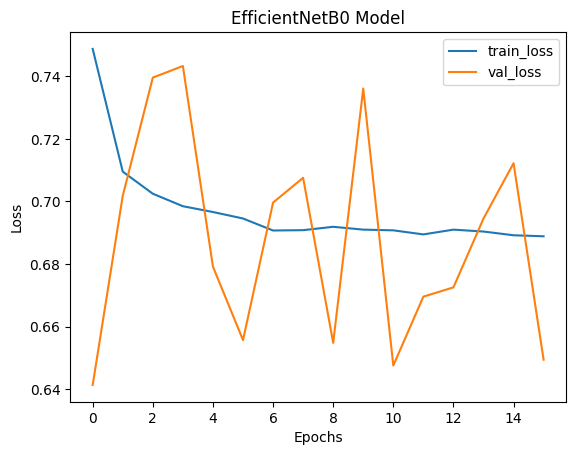

126/126 [==============================] - 17s 129ms/step - loss: 0.8114 - accuracy: 0.3953
EfficientNetB0 Test Loss: 0.8114075064659119
EfficientNetB0 Test Accuracy: 0.39533731341362
1/1 [==============================] - 0s 57ms/step
EfficientNetB0 Classification Report:
               precision    recall  f1-score   support

           0       0.40      1.00      0.57      1594
           1       1.00      0.00      0.00      2438

    accuracy                           0.40      4032
   macro avg       0.70      0.50      0.28      4032
weighted avg       0.76      0.40      0.22      4032

EfficientNetB0 Confusion Matrix:
 [[1594    0]
 [2438    0]]


In [ ]:
efficientnet_model = EfficientNetB0(include_top=False, input_shape=(299, 299, 3))

for layer in efficientnet_model.layers:
    layer.trainable = False

efficientnet_model.layers[-1].trainable = True
num_classes = 1

efficientnet_model = Sequential([
    efficientnet_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(num_classes, activation='sigmoid')
])

efficientnet_model.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

efficientnet_history = efficientnet_model.fit(tf_dataset_train, epochs=25, validation_data=tf_dataset_val, callbacks=[early_stopping])

# Plot training and validation errors
plt.plot(efficientnet_history.history['loss'], label='train_loss')
plt.plot(efficientnet_history.history['val_loss'], label='val_loss')
plt.title('EfficientNetB0 Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate model
efficientnet_loss, efficientnet_accuracy = efficientnet_model.evaluate(tf_dataset_test)

print("EfficientNetB0 Test Loss:", efficientnet_loss)
print("EfficientNetB0 Test Accuracy:", efficientnet_accuracy)

# Classification Report and Confusion Matrix
y_true_eff = []
y_pred_eff = []

for images, labels in tf_dataset_test:
    y_true_eff.extend(labels.numpy())
    y_pred_eff.extend(np.argmax(efficientnet_model.predict(images), axis=1))

efficientnet_report = classification_report(y_true_eff, y_pred_eff, zero_division=1)
print("EfficientNetB0 Classification Report:\n", efficientnet_report)

efficientnet_confusion_mtx = confusion_matrix(y_true_eff, y_pred_eff)
print("EfficientNetB0 Confusion Matrix:\n", efficientnet_confusion_mtx)

## EfficientNetB0 Model with Data Augmentation Appended

16705208/16705208 [==============================] - 1s 0us/step
Epoch 1/25
341/341 [==============================] - 114s 314ms/step - loss: 0.7308 - accuracy: 0.5283 - val_loss: 0.6342 - val_accuracy: 0.6763
Epoch 2/25
341/341 [==============================] - 105s 307ms/step - loss: 0.7109 - accuracy: 0.5238 - val_loss: 0.6706 - val_accuracy: 0.6763
Epoch 3/25
341/341 [==============================] - 105s 308ms/step - loss: 0.6991 - accuracy: 0.5322 - val_loss: 0.8211 - val_accuracy: 0.3237
Epoch 4/25
341/341 [==============================] - 104s 306ms/step - loss: 0.6972 - accuracy: 0.5298 - val_loss: 0.6935 - val_accuracy: 0.6763
Epoch 5/25
341/341 [==============================] - 104s 304ms/step - loss: 0.6918 - accuracy: 0.5400 - val_loss: 0.6546 - val_accuracy: 0.6763
Epoch 6/25
341/341 [==============================] - 104s 306ms/step - loss: 0.6909 - accuracy: 0.5424 - val_loss: 0.6822 - val_accuracy: 0.6763
Epoch 7/25
341/341 [==============================] - 107s 

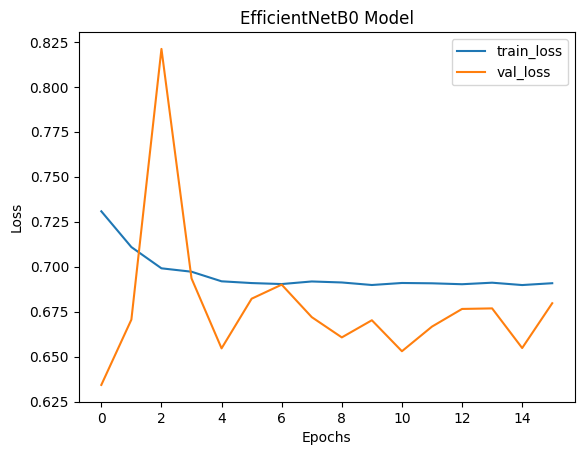

126/126 [==============================] - 17s 136ms/step - loss: 0.7894 - accuracy: 0.3953
EfficientNetB0 Test Loss: 0.7893742918968201
EfficientNetB0 Test Accuracy: 0.39533731341362
1/1 [==============================] - 0s 57ms/step
EfficientNetB0 Classification Report:
               precision    recall  f1-score   support

           0       0.40      1.00      0.57      1594
           1       1.00      0.00      0.00      2438

    accuracy                           0.40      4032
   macro avg       0.70      0.50      0.28      4032
weighted avg       0.76      0.40      0.22      4032

EfficientNetB0 Confusion Matrix:
 [[1594    0]
 [2438    0]]


In [ ]:
efficientnet_model = EfficientNetB0(include_top=False, input_shape=(299, 299, 3))

for layer in efficientnet_model.layers:
    layer.trainable = False

efficientnet_model.layers[-1].trainable = True
num_classes = 1

efficientnet_model = Sequential([
    efficientnet_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(num_classes, activation='sigmoid')
])

efficientnet_model.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

efficientnet_history = efficientnet_model.fit(tf_dataset_train_aug_final, epochs=25, validation_data=tf_dataset_val, callbacks=[early_stopping])

# Plot training and validation errors
plt.plot(efficientnet_history.history['loss'], label='train_loss')
plt.plot(efficientnet_history.history['val_loss'], label='val_loss')
plt.title('EfficientNetB0 Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate model
efficientnet_loss, efficientnet_accuracy = efficientnet_model.evaluate(tf_dataset_test)

print("EfficientNetB0 Test Loss:", efficientnet_loss)
print("EfficientNetB0 Test Accuracy:", efficientnet_accuracy)

# Classification Report and Confusion Matrix
y_true_eff = []
y_pred_eff = []

for images, labels in tf_dataset_test:
    y_true_eff.extend(labels.numpy())
    y_pred_eff.extend(np.argmax(efficientnet_model.predict(images), axis=1))

efficientnet_report = classification_report(y_true_eff, y_pred_eff, zero_division=1)
print("EfficientNetB0 Classification Report:\n", efficientnet_report)

efficientnet_confusion_mtx = confusion_matrix(y_true_eff, y_pred_eff)
print("EfficientNetB0 Confusion Matrix:\n", efficientnet_confusion_mtx)

## EfficientNetB0 Model with Data Augmentation

04:25:35 | WARNING | optimizer       | At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`.


Epoch 1/25


2023-12-08 04:25:37.715457: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


442/442 [==============================] - 264s 585ms/step - loss: 0.6063 - accuracy: 0.6638 - val_loss: 3.2913 - val_accuracy: 0.2310
Epoch 2/25
442/442 [==============================] - 257s 576ms/step - loss: 0.5524 - accuracy: 0.6988 - val_loss: 0.6553 - val_accuracy: 0.6172
Epoch 3/25
442/442 [==============================] - 261s 589ms/step - loss: 0.5457 - accuracy: 0.6979 - val_loss: 0.9551 - val_accuracy: 0.7690
Epoch 4/25
442/442 [==============================] - 263s 594ms/step - loss: 0.5390 - accuracy: 0.7037 - val_loss: 0.6820 - val_accuracy: 0.7690
Epoch 5/25
442/442 [==============================] - 257s 577ms/step - loss: 0.5371 - accuracy: 0.7056 - val_loss: 1.0739 - val_accuracy: 0.7690
Epoch 6/25
442/442 [==============================] - 250s 565ms/step - loss: 0.5342 - accuracy: 0.7088 - val_loss: 0.7630 - val_accuracy: 0.7690
Epoch 7/25
442/442 [==============================] - 248s 560ms/step - loss: 0.5307 - accuracy: 0.7101 - val_loss: 0.6148 - val_accura

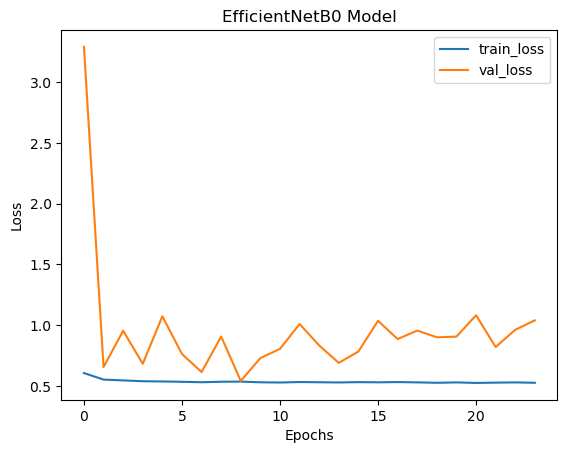

250/250 [==============================] - 81s 322ms/step - loss: 1.7315 - accuracy: 0.2757
EfficientNetB0 Test Loss: 1.7314894199371338
EfficientNetB0 Test Accuracy: 0.2757149934768677
1/1 [==============================] - 2s 2s/step
EfficientNetB0 Classification Report:
               precision    recall  f1-score   support

           0       0.28      1.00      0.43      2198
           1       1.00      0.00      0.00      5774

    accuracy                           0.28      7972
   macro avg       0.64      0.50      0.22      7972
weighted avg       0.80      0.28      0.12      7972

EfficientNetB0 Confusion Matrix:
 [[2198    0]
 [5774    0]]


In [15]:
efficientnet_model = EfficientNetB0(include_top=False, input_shape=(299, 299, 3))

for layer in efficientnet_model.layers:
    layer.trainable = False

efficientnet_model.layers[-1].trainable = True
num_classes = 1

efficientnet_model = Sequential([
    efficientnet_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(num_classes, activation='sigmoid')
])

efficientnet_model.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

efficientnet_history = efficientnet_model.fit(tf_dataset_train_aug, epochs=25, validation_data=tf_dataset_val, callbacks=[early_stopping])

# Plot training and validation errors
plt.plot(efficientnet_history.history['loss'], label='train_loss')
plt.plot(efficientnet_history.history['val_loss'], label='val_loss')
plt.title('EfficientNetB0 Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate model
efficientnet_loss, efficientnet_accuracy = efficientnet_model.evaluate(tf_dataset_test)

print("EfficientNetB0 Test Loss:", efficientnet_loss)
print("EfficientNetB0 Test Accuracy:", efficientnet_accuracy)

# Classification Report and Confusion Matrix
y_true_eff = []
y_pred_eff = []

for images, labels in tf_dataset_test:
    y_true_eff.extend(labels.numpy())
    y_pred_eff.extend(np.argmax(efficientnet_model.predict(images), axis=1))

efficientnet_report = classification_report(y_true_eff, y_pred_eff, zero_division=1)
print("EfficientNetB0 Classification Report:\n", efficientnet_report)

efficientnet_confusion_mtx = confusion_matrix(y_true_eff, y_pred_eff)
print("EfficientNetB0 Confusion Matrix:\n", efficientnet_confusion_mtx)

## ResNet50 Model without Data Augmentation

11:23:27 | WARNING | optimizer       | At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`.


Epoch 1/25


2023-12-08 11:23:28.805730: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2023-12-08 11:23:28.897342: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


442/442 [==============================] - 275s 618ms/step - loss: 0.2402 - accuracy: 0.9018 - val_loss: 0.2609 - val_accuracy: 0.8945
Epoch 2/25
442/442 [==============================] - 273s 618ms/step - loss: 0.1881 - accuracy: 0.9250 - val_loss: 2.0916 - val_accuracy: 0.4184
Epoch 3/25
442/442 [==============================] - 273s 616ms/step - loss: 0.1750 - accuracy: 0.9297 - val_loss: 0.4013 - val_accuracy: 0.8824
Epoch 4/25
442/442 [==============================] - 273s 617ms/step - loss: 0.1652 - accuracy: 0.9347 - val_loss: 5.8877 - val_accuracy: 0.2362
Epoch 5/25
442/442 [==============================] - 274s 618ms/step - loss: 0.1576 - accuracy: 0.9372 - val_loss: 6.7509 - val_accuracy: 0.2359
Epoch 6/25
442/442 [==============================] - 274s 618ms/step - loss: 0.1556 - accuracy: 0.9390 - val_loss: 2.0511 - val_accuracy: 0.4309
Epoch 7/25
442/442 [==============================] - 278s 628ms/step - loss: 0.1499 - accuracy: 0.9412 - val_loss: 8.3757 - val_accura

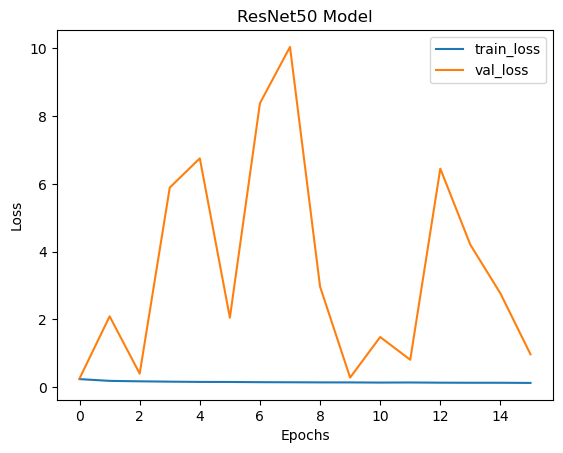

250/250 [==============================] - 97s 386ms/step - loss: 0.7948 - accuracy: 0.7268
ResNet50 Test Loss: 0.7947808504104614
ResNet50 Test Accuracy: 0.7267937660217285
1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 1s 858ms/step
ResNet50 Classification Report:
               precision    recall  f1-score   support

           0       0.28      1.00      0.43      2198
           1       1.00      0.00      0.00      5774

    accuracy                           0.28      7972
   macro avg       0.64      0.50      0.22      7972
weighted avg       0.80      0.28      0.12      7972

ResNet50 Confusion Matrix:
 [[2198    0]
 [5774    0]]


In [12]:
resnet_model = ResNet50(include_top=False, input_shape=(299, 299, 3))

for layer in resnet_model.layers[:-1]:
    layer.trainable = False

num_classes = 1

resnet_model = Sequential([
    resnet_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(num_classes, activation='sigmoid')
])

resnet_model.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

resnet_history = resnet_model.fit(tf_dataset_train, epochs=25, validation_data=tf_dataset_val, callbacks=[early_stopping])

# Plot training and validation errors
plt.plot(resnet_history.history['loss'], label='train_loss')
plt.plot(resnet_history.history['val_loss'], label='val_loss')
plt.title('ResNet50 Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate model
resnet_loss, resnet_accuracy = resnet_model.evaluate(tf_dataset_test)

print("ResNet50 Test Loss:", resnet_loss)
print("ResNet50 Test Accuracy:", resnet_accuracy)

# Classification Report and Confusion Matrix
y_true_resnet = []
y_pred_resnet = []

for images, labels in tf_dataset_test:
    y_true_resnet.extend(labels.numpy())
    y_pred_resnet.extend(np.argmax(resnet_model.predict(images), axis=1))

resnet_report = classification_report(y_true_resnet, y_pred_resnet, zero_division=1)
print("ResNet50 Classification Report:\n", resnet_report)

resnet_confusion_mtx = confusion_matrix(y_true_resnet, y_pred_resnet)
print("ResNet50 Confusion Matrix:\n", resnet_confusion_mtx)

## ResNet50 Model with Data Augmentation Appended

94765736/94765736 [==============================] - 3s 0us/step
Epoch 1/25
341/341 [==============================] - 187s 456ms/step - loss: 0.3646 - accuracy: 0.8376 - val_loss: 0.6804 - val_accuracy: 0.6763
Epoch 2/25
341/341 [==============================] - 155s 454ms/step - loss: 0.3659 - accuracy: 0.8315 - val_loss: 0.7248 - val_accuracy: 0.4091
Epoch 3/25
341/341 [==============================] - 156s 457ms/step - loss: 0.2926 - accuracy: 0.8760 - val_loss: 1.2791 - val_accuracy: 0.3566
Epoch 4/25
341/341 [==============================] - 155s 453ms/step - loss: 0.2061 - accuracy: 0.9179 - val_loss: 2.4806 - val_accuracy: 0.3237
Epoch 5/25
341/341 [==============================] - 155s 454ms/step - loss: 0.1797 - accuracy: 0.9301 - val_loss: 4.3572 - val_accuracy: 0.4292
Epoch 6/25
341/341 [==============================] - 153s 447ms/step - loss: 0.1816 - accuracy: 0.9277 - val_loss: 7.1045 - val_accuracy: 0.4614
Epoch 7/25
341/341 [==============================] - 152s 

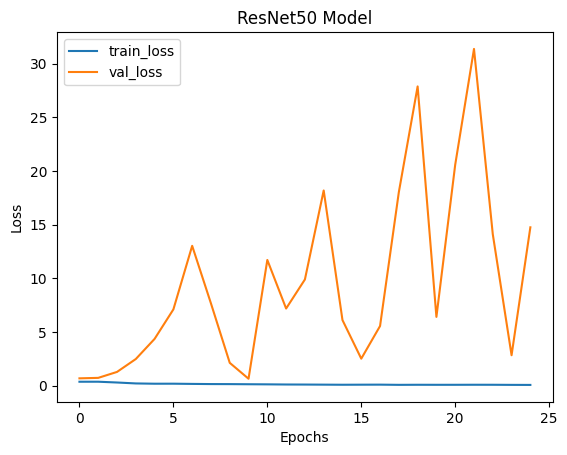

126/126 [==============================] - 18s 143ms/step - loss: 5.7288 - accuracy: 0.4380
ResNet50 Test Loss: 5.728815078735352
ResNet50 Test Accuracy: 0.4379960298538208
1/1 [==============================] - 0s 53ms/step
ResNet50 Classification Report:
               precision    recall  f1-score   support

           0       0.40      1.00      0.57      1594
           1       1.00      0.00      0.00      2438

    accuracy                           0.40      4032
   macro avg       0.70      0.50      0.28      4032
weighted avg       0.76      0.40      0.22      4032

ResNet50 Confusion Matrix:
 [[1594    0]
 [2438    0]]


In [ ]:
resnet_model = ResNet50(include_top=False, input_shape=(299, 299, 3))

for layer in resnet_model.layers[:-1]:
    layer.trainable = False

num_classes = 1

resnet_model = Sequential([
    resnet_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(num_classes, activation='sigmoid')
])

resnet_model.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

resnet_history = resnet_model.fit(tf_dataset_train_aug_final, epochs=25, validation_data=tf_dataset_val, callbacks=[early_stopping])

# Plot training and validation errors
plt.plot(resnet_history.history['loss'], label='train_loss')
plt.plot(resnet_history.history['val_loss'], label='val_loss')
plt.title('ResNet50 Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate model
resnet_loss, resnet_accuracy = resnet_model.evaluate(tf_dataset_test)

print("ResNet50 Test Loss:", resnet_loss)
print("ResNet50 Test Accuracy:", resnet_accuracy)

# Classification Report and Confusion Matrix
y_true_resnet = []
y_pred_resnet = []

for images, labels in tf_dataset_test:
    y_true_resnet.extend(labels.numpy())
    y_pred_resnet.extend(np.argmax(resnet_model.predict(images), axis=1))

resnet_report = classification_report(y_true_resnet, y_pred_resnet, zero_division=1)
print("ResNet50 Classification Report:\n", resnet_report)

resnet_confusion_mtx = confusion_matrix(y_true_resnet, y_pred_resnet)
print("ResNet50 Confusion Matrix:\n", resnet_confusion_mtx)

## ResNet50 Model with Data Augmentation

02:22:44 | WARNING | optimizer       | At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`.


Epoch 1/25


2023-12-08 02:22:46.497952: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


442/442 [==============================] - 287s 645ms/step - loss: 0.5140 - accuracy: 0.7256 - val_loss: 5.0906 - val_accuracy: 0.2310
Epoch 2/25
442/442 [==============================] - 286s 647ms/step - loss: 0.4847 - accuracy: 0.7461 - val_loss: 4.7063 - val_accuracy: 0.7690
Epoch 3/25
442/442 [==============================] - 285s 644ms/step - loss: 0.4777 - accuracy: 0.7511 - val_loss: 4.0271 - val_accuracy: 0.7688
Epoch 4/25
442/442 [==============================] - 290s 655ms/step - loss: 0.4663 - accuracy: 0.7576 - val_loss: 8.7493 - val_accuracy: 0.2433
Epoch 5/25
442/442 [==============================] - 287s 648ms/step - loss: 0.4606 - accuracy: 0.7663 - val_loss: 12.8045 - val_accuracy: 0.2325
Epoch 6/25
442/442 [==============================] - 285s 645ms/step - loss: 0.4598 - accuracy: 0.7640 - val_loss: 9.7722 - val_accuracy: 0.2367
Epoch 7/25
442/442 [==============================] - 300s 676ms/step - loss: 0.4525 - accuracy: 0.7707 - val_loss: 16.2726 - val_accu

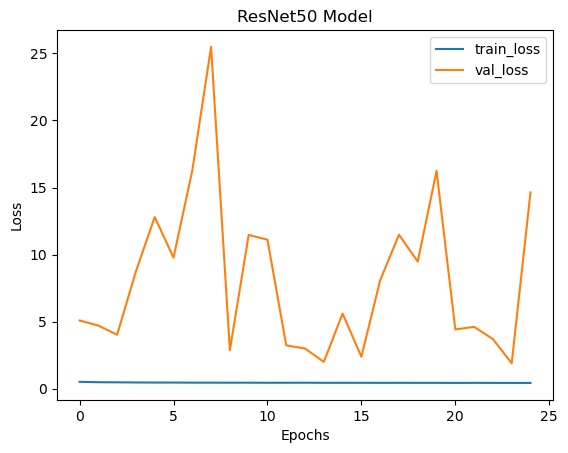

250/250 [==============================] - 97s 387ms/step - loss: 4.5713 - accuracy: 0.7224
ResNet50 Test Loss: 4.571260929107666
ResNet50 Test Accuracy: 0.7224034070968628
1/1 [==============================] - 1s 728ms/step
ResNet50 Classification Report:
               precision    recall  f1-score   support

           0       0.28      1.00      0.43      2198
           1       1.00      0.00      0.00      5774

    accuracy                           0.28      7972
   macro avg       0.64      0.50      0.22      7972
weighted avg       0.80      0.28      0.12      7972

ResNet50 Confusion Matrix:
 [[2198    0]
 [5774    0]]


In [14]:
resnet_model = ResNet50(include_top=False, input_shape=(299, 299, 3))

for layer in resnet_model.layers[:-1]:
  layer.trainable = False

num_classes = 1

resnet_model = Sequential([
    resnet_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(num_classes, activation='sigmoid')
])

resnet_model.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

resnet_history = resnet_model.fit(tf_dataset_train_aug, epochs=25, validation_data=tf_dataset_val, callbacks=[early_stopping])

# Plot training and validation errors
plt.plot(resnet_history.history['loss'], label='train_loss')
plt.plot(resnet_history.history['val_loss'], label='val_loss')
plt.title('ResNet50 Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate model
resnet_loss, resnet_accuracy = resnet_model.evaluate(tf_dataset_test)

print("ResNet50 Test Loss:", resnet_loss)
print("ResNet50 Test Accuracy:", resnet_accuracy)

# Classification Report and Confusion Matrix
y_true_resnet = []
y_pred_resnet = []

for images, labels in tf_dataset_test:
    y_true_resnet.extend(labels.numpy())
    y_pred_resnet.extend(np.argmax(resnet_model.predict(images), axis=1))

resnet_report = classification_report(y_true_resnet, y_pred_resnet, zero_division=1)
print("ResNet50 Classification Report:\n", resnet_report)

resnet_confusion_mtx = confusion_matrix(y_true_resnet, y_pred_resnet)
print("ResNet50 Confusion Matrix:\n", resnet_confusion_mtx)

## VGG16 Model without Data Augmentation

58889256/58889256 [==============================] - 2s 0us/step
Epoch 1/25
257/257 [==============================] - 63s 233ms/step - loss: 0.1411 - accuracy: 0.9452 - val_loss: 0.4215 - val_accuracy: 0.7647
Epoch 2/25
257/257 [==============================] - 58s 225ms/step - loss: 0.0930 - accuracy: 0.9657 - val_loss: 0.6629 - val_accuracy: 0.8258
Epoch 3/25
257/257 [==============================] - 58s 225ms/step - loss: 0.0850 - accuracy: 0.9678 - val_loss: 1.1045 - val_accuracy: 0.7696
Epoch 4/25
257/257 [==============================] - 58s 225ms/step - loss: 0.0758 - accuracy: 0.9711 - val_loss: 1.5710 - val_accuracy: 0.7378
Epoch 5/25
257/257 [==============================] - 58s 224ms/step - loss: 0.0732 - accuracy: 0.9724 - val_loss: 2.4874 - val_accuracy: 0.6503
Epoch 6/25
257/257 [==============================] - 58s 225ms/step - loss: 0.0684 - accuracy: 0.9733 - val_loss: 1.6175 - val_accuracy: 0.7167
Epoch 7/25
257/257 [==============================] - 58s 226ms/s

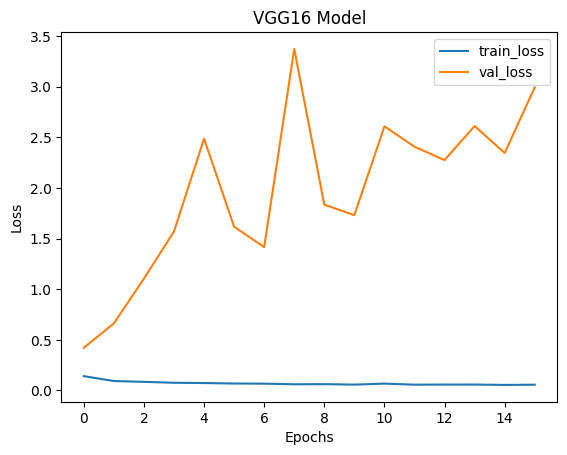

126/126 [==============================] - 22s 169ms/step - loss: 0.4383 - accuracy: 0.7865
VGG16 Test Loss: 0.4383060336112976
VGG16 Test Accuracy: 0.7864583134651184
1/1 [==============================] - 0s 51ms/step
VGG16 Classification Report:
               precision    recall  f1-score   support

           0       0.40      1.00      0.57      1594
           1       1.00      0.00      0.00      2438

    accuracy                           0.40      4032
   macro avg       0.70      0.50      0.28      4032
weighted avg       0.76      0.40      0.22      4032

VGG16 Confusion Matrix:
 [[1594    0]
 [2438    0]]


In [ ]:
vgg16_model = VGG16(include_top=False, input_shape=(299, 299, 3))

for layer in vgg16_model.layers[:-1]:
    layer.trainable = False

num_classes = 1

vgg16_model = Sequential([
    vgg16_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(num_classes, activation='sigmoid')
])

vgg16_model.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

vgg16_history = vgg16_model.fit(tf_dataset_train, epochs=25, validation_data=tf_dataset_val, callbacks=[early_stopping])

# Plot training and validation errors
plt.plot(vgg16_history.history['loss'], label='train_loss')
plt.plot(vgg16_history.history['val_loss'], label='val_loss')
plt.title('VGG16 Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate model
vgg16_loss, vgg16_accuracy = vgg16_model.evaluate(tf_dataset_test)

print("VGG16 Test Loss:", vgg16_loss)
print("VGG16 Test Accuracy:", vgg16_accuracy)

# Classification Report and Confusion Matrix
y_true_vgg16 = []
y_pred_vgg16 = []

for images, labels in tf_dataset_test:
    y_true_vgg16.extend(labels.numpy())
    y_pred_vgg16.extend(np.argmax(vgg16_model.predict(images), axis=1))

vgg16_report = classification_report(y_true_vgg16, y_pred_vgg16, zero_division=1)
print("VGG16 Classification Report:\n", vgg16_report)

vgg16_confusion_mtx = confusion_matrix(y_true_vgg16, y_pred_vgg16)
print("VGG16 Confusion Matrix:\n", vgg16_confusion_mtx)

## VGG16 Model with Data Augmentation Appended

58889256/58889256 [==============================] - 2s 0us/step
Epoch 1/25
341/341 [==============================] - 121s 344ms/step - loss: 0.2790 - accuracy: 0.8697 - val_loss: 0.8322 - val_accuracy: 0.6786
Epoch 2/25
341/341 [==============================] - 117s 343ms/step - loss: 0.2455 - accuracy: 0.8839 - val_loss: 1.4101 - val_accuracy: 0.6093
Epoch 3/25
341/341 [==============================] - 117s 342ms/step - loss: 0.2299 - accuracy: 0.8920 - val_loss: 1.6648 - val_accuracy: 0.5281
Epoch 4/25
341/341 [==============================] - 117s 342ms/step - loss: 0.2246 - accuracy: 0.8911 - val_loss: 2.2832 - val_accuracy: 0.5902
Epoch 5/25
341/341 [==============================] - 117s 342ms/step - loss: 0.2211 - accuracy: 0.8926 - val_loss: 1.8560 - val_accuracy: 0.5094
Epoch 6/25
341/341 [==============================] - 117s 344ms/step - loss: 0.2132 - accuracy: 0.8979 - val_loss: 1.5677 - val_accuracy: 0.6053
Epoch 7/25
341/341 [==============================] - 117s 

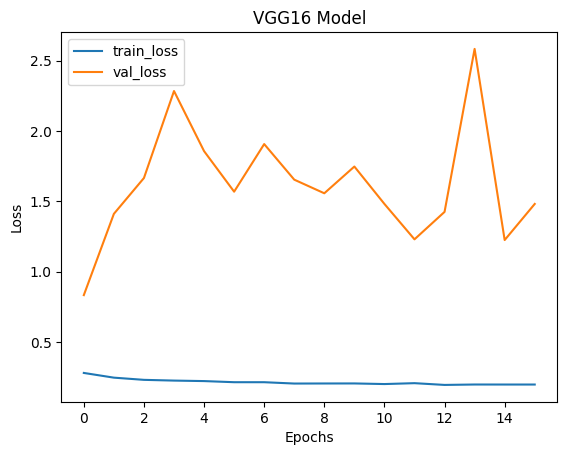

126/126 [==============================] - 21s 162ms/step - loss: 0.9504 - accuracy: 0.5320
VGG16 Test Loss: 0.9503723382949829
VGG16 Test Accuracy: 0.5319940447807312
1/1 [==============================] - 0s 50ms/step
VGG16 Classification Report:
               precision    recall  f1-score   support

           0       0.40      1.00      0.57      1594
           1       1.00      0.00      0.00      2438

    accuracy                           0.40      4032
   macro avg       0.70      0.50      0.28      4032
weighted avg       0.76      0.40      0.22      4032

VGG16 Confusion Matrix:
 [[1594    0]
 [2438    0]]


In [ ]:
vgg16_model = VGG16(include_top=False, input_shape=(299, 299, 3))

for layer in vgg16_model.layers[:-1]:
    layer.trainable = False

num_classes = 1

vgg16_model = Sequential([
    vgg16_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(num_classes, activation='sigmoid')
])

vgg16_model.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

vgg16_history = vgg16_model.fit(tf_dataset_train_aug_final, epochs=25, validation_data=tf_dataset_val, callbacks=[early_stopping])

# Plot training and validation errors
plt.plot(vgg16_history.history['loss'], label='train_loss')
plt.plot(vgg16_history.history['val_loss'], label='val_loss')
plt.title('VGG16 Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate model
vgg16_loss, vgg16_accuracy = vgg16_model.evaluate(tf_dataset_test)

print("VGG16 Test Loss:", vgg16_loss)
print("VGG16 Test Accuracy:", vgg16_accuracy)

# Classification Report and Confusion Matrix
y_true_vgg16 = []
y_pred_vgg16 = []

for images, labels in tf_dataset_test:
    y_true_vgg16.extend(labels.numpy())
    y_pred_vgg16.extend(np.argmax(vgg16_model.predict(images), axis=1))

vgg16_report = classification_report(y_true_vgg16, y_pred_vgg16, zero_division=1)
print("VGG16 Classification Report:\n", vgg16_report)

vgg16_confusion_mtx = confusion_matrix(y_true_vgg16, y_pred_vgg16)
print("VGG16 Confusion Matrix:\n", vgg16_confusion_mtx)

## VGG16 Model with Data Augmentation

00:31:46 | WARNING | optimizer       | At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`.


Epoch 1/25


2023-12-08 00:31:47.141927: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2023-12-08 00:31:47.178405: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


442/442 [==============================] - 400s 901ms/step - loss: 0.3712 - accuracy: 0.8321 - val_loss: 3.2631 - val_accuracy: 0.2344
Epoch 2/25
442/442 [==============================] - 404s 914ms/step - loss: 0.3157 - accuracy: 0.8635 - val_loss: 10.5038 - val_accuracy: 0.2320
Epoch 3/25
442/442 [==============================] - 398s 900ms/step - loss: 0.2929 - accuracy: 0.8741 - val_loss: 7.7106 - val_accuracy: 0.3282
Epoch 4/25
442/442 [==============================] - 397s 898ms/step - loss: 0.2908 - accuracy: 0.8741 - val_loss: 13.1188 - val_accuracy: 0.2571
Epoch 5/25
442/442 [==============================] - 400s 905ms/step - loss: 0.2844 - accuracy: 0.8791 - val_loss: 14.7644 - val_accuracy: 0.2403
Epoch 6/25
442/442 [==============================] - 400s 906ms/step - loss: 0.2747 - accuracy: 0.8824 - val_loss: 9.9416 - val_accuracy: 0.3507
Epoch 7/25
442/442 [==============================] - 398s 901ms/step - loss: 0.2738 - accuracy: 0.8845 - val_loss: 17.4027 - val_ac

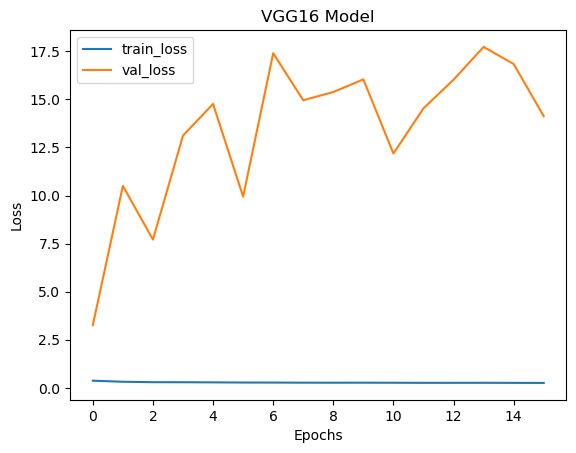

250/250 [==============================] - 139s 555ms/step - loss: 0.8142 - accuracy: 0.7397
VGG16 Test Loss: 0.8142387866973877
VGG16 Test Accuracy: 0.7397140264511108
1/1 [==============================] - 0s 215ms/step
VGG16 Classification Report:
               precision    recall  f1-score   support

           0       0.28      1.00      0.43      2198
           1       1.00      0.00      0.00      5774

    accuracy                           0.28      7972
   macro avg       0.64      0.50      0.22      7972
weighted avg       0.80      0.28      0.12      7972

VGG16 Confusion Matrix:
 [[2198    0]
 [5774    0]]


In [13]:
vgg16_model = VGG16(include_top=False, input_shape=(299, 299, 3))

for layer in vgg16_model.layers[:-1]:
    layer.trainable = False

num_classes = 1

vgg16_model = Sequential([
    vgg16_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(num_classes, activation='sigmoid')
])

vgg16_model.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

vgg16_history = vgg16_model.fit(tf_dataset_train_aug, epochs=25, validation_data=tf_dataset_val, callbacks=[early_stopping])

# Plot training and validation errors
plt.plot(vgg16_history.history['loss'], label='train_loss')
plt.plot(vgg16_history.history['val_loss'], label='val_loss')
plt.title('VGG16 Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate model
vgg16_loss, vgg16_accuracy = vgg16_model.evaluate(tf_dataset_test)

print("VGG16 Test Loss:", vgg16_loss)
print("VGG16 Test Accuracy:", vgg16_accuracy)

# Classification Report and Confusion Matrix
y_true_vgg16 = []
y_pred_vgg16 = []

for images, labels in tf_dataset_test:
    y_true_vgg16.extend(labels.numpy())
    y_pred_vgg16.extend(np.argmax(vgg16_model.predict(images), axis=1))

vgg16_report = classification_report(y_true_vgg16, y_pred_vgg16, zero_division=1)
print("VGG16 Classification Report:\n", vgg16_report)

vgg16_confusion_mtx = confusion_matrix(y_true_vgg16, y_pred_vgg16)
print("VGG16 Confusion Matrix:\n", vgg16_confusion_mtx)

| Sr. No. | Model | Test Loss | Test Accuracy |
| :- | :- | :- | :- |
| 1. | CNN w/o Data Augmentation | 0.4091 | 91.27%
| 2. | CNN w/ Data Augmentation Appended | 1.2907 | 62.77%
| 3. | CNN w/ Data Augmentation | 4.4383 | 40.53%
|  |  |  |  |
| 4. | EfficientNet w/o Data Augmentation | 0.8114 | 39.53%
| 5. | EfficientNet w/ Data Augmentation Appended | 0.7894 | 39.53%
| 6. | EfficientNet w/ Data Augmentation | 1.7315 | 27.57%
|  |  |  |  |
| 7. | ResNet50 w/o Data Augmentation | 0.7948 | 72.68%
| 8. | ResNet50 w/ Data Augmentation Appended | 5.7288 | 43.80%
| 9. | ResNet50 w/ Data Augmentation | 4.5713 | 72.24%
|  |  |  |  |
| 10. | VGG16 w/o Data Augmentation | 0.4383 | 78.65%
| 11. | VGG16 w/ Data Augmentation Appended | 0.9504 | 53.20%
| 12. | VGG16 w/ Data Augmentation | 0.8142 | 73.97%

## Analysis of Model Performance with and without Data Augmentation

### Impact of Augmentation on Custom CNN and Transfer Learning Models:
#### Custom CNN:
The introduction of augmented data, both appended and standalone, led to a reduction in test accuracy compared to the model trained on the original un-augmented data. This indicates that, in this case, data augmentation may not have contributed positively to the CNN's performance.

#### EfficientNet:
EfficientNet exhibited a trend where applying data augmentation and appending it to the training set did not significantly affect test accuracy. However, it did result in a reduction in test loss. Augmenting all training data, surprisingly, reduced test accuracy. Further investigation might be required to understand the nuances of EfficientNet's response to augmentation.

#### ResNet50:
Unlike the custom CNN and EfficientNet, ResNet50 only showcased an decline in test accuracy when augmented data was appended. This implies that independent data augmentation benefited the transfer learning of ResNet50.

#### VGG16:
The behavior of VGG16 was unique, where appending augmented data to the original set decreased test accuracy, but augmenting all training data led to a relative increase in test accuracy. Understanding the specific characteristics of VGG16's response to augmentation can guide future model adjustments.


### Transfer Learning vs Custom CNN:
#### Custom CNN vs Transfer Learning Models:
While state-of-the-art transfer learning models like EfficientNet, ResNet50, and VGG16 are pretrained on extensive datasets, they may not universally outperform a well-designed custom CNN for every use case.

The custom CNN achieved the highest test accuracy at 91.27%, showcasing its effectiveness for this specific task. In contrast, EfficientNet struggled to surpass 39.53% accuracy across all cases.

#### Performance Variation with Data Augmentation:
Notably, despite the custom CNN's strong performance on unaugmented data, ResNet50 and VGG16 surpassed its accuracy by over 30% points when evaluated on augmented data. This underscores the importance of considering data augmentation when choosing between custom CNNs and transfer learning models.